# Vectorization
---

## Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
current_folder = "/content/gdrive/My Drive/Workshop/TOM/"
os.chdir(current_folder)

## Clean Data Loading

In [26]:
import pandas as pd
df = pd.read_csv("repos.csv", encoding="latin1")
df.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
20846,20846,NaN,NaN,MEMBER,Improvement for the new mkdocs-based documenta...,NaN,1,https://api.github.com/repos/testcontainers/te...,2019-01-20T10:57:11Z,NaN,https://api.github.com/repos/testcontainers/te...,https://github.com/testcontainers/testcontaine...,401085654,https://api.github.com/repos/testcontainers/te...,False,NaN,MDU6SXNzdWU0MDEwODU2NTQ=,1164,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/testcontainers/te...,https://api.github.com/repos/testcontainers/te...,open,https://api.github.com/repos/testcontainers/te...,New docs: document use of APIs for copying fil...,2019-04-20T11:14:15Z,https://api.github.com/repos/testcontainers/te...,New document use of for copying files containers,with code,Improvement for the new Add to with examples b...,with code
14193,14193,NaN,NaN,NONE,Spring cloud gateway version : 3.0.5\r\n\r\nWe...,NaN,0,https://api.github.com/repos/spring-cloud/spri...,2021-12-10T06:29:51Z,NaN,https://api.github.com/repos/spring-cloud/spri...,https://github.com/spring-cloud/spring-cloud-g...,1076491151,https://api.github.com/repos/spring-cloud/spri...,False,NaN,I_kwDOBGiZO85AKfOP,2458,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-cloud/spri...,https://api.github.com/repos/spring-cloud/spri...,open,https://api.github.com/repos/spring-cloud/spri...,spring cloud gateway multiple retry filters,2021-12-10T06:29:51Z,https://api.github.com/repos/spring-cloud/spri...,spring cloud gateway multiple retry filters,without code,Spring cloud gateway version We want to have m...,with code


In [27]:
length_before = df.shape[0]
df.dropna(subset=["clean_title"], inplace=True)
length_after = df.shape[0]
print("We droped {} elements of {}".format(length_before - length_after, length_before))

We droped 2715 elements of 34268


In [28]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head(2)

,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
0,NaN,NaN,NONE,I put the problem in MD,NaN,1,https://api.github.com/repos/spring-projects/s...,2021-12-11T02:13:23Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077359600,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANzPw,28991,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,JDK17 And SpringBoot-3.0.0-SNAPSHOT,2021-12-11T02:16:56Z,https://api.github.com/repos/spring-projects/s...,And,with code,I put the problem in,without code
1,NaN,NaN,NONE,"I cannot include the actual code here, but I w...",NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-10T22:32:04Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077283209,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANgmJ,28990,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Dev Tools: Request Scoped Bean Not Working Whe...,2021-12-11T00:46:11Z,https://api.github.com/repos/spring-projects/s...,Dev Request Scoped Bean Not Working When Inclu...,with code,I cannot include the actual code but I will cr...,with code


In [29]:
from collections import defaultdict
dicc = defaultdict(int)

for element in df["clean_title"]:
    dicc[str(type(element))] += 1

dicc

defaultdict(int, {"<class 'str'>": 31553})

In [30]:
titles_no_code = df[df["code_title"]=="without code"]
titles_no_code.shape

(17749, 38)

In [31]:
titles_no_code.head(3)

,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
2,NaN,NaN,NONE,I've got a problem from migrating from SB 2.3 ...,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T09:06:49Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076600016,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK5zQ,28977,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,DatabaseInitializationDependencyConfigurer tri...,2021-12-10T14:44:37Z,https://api.github.com/repos/spring-projects/s...,triggers eager initialization of factory beans,without code,got a problem from migrating from to When havi...,with code
3,NaN,NaN,MEMBER,NaN,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T08:44:05Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076581722,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK1Va,28976,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,2021-12-10T15:37:23Z,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,without code,NaN,without code
16,NaN,NaN,MEMBER,NaN,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-09T17:41:02Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1075834267,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AH-2b,28955,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Document that using DevTools with a remote app...,2021-12-09T17:41:02Z,https://api.github.com/repos/spring-projects/s...,Document that using with a remote application ...,without code,NaN,without code


## The Corpus

In [8]:
# corpus = [text.lower() for text in df["clean_title"].values if text!=""]
# print("We are using {} titles of {}".format(len(corpus), df.shape[0]))
corpus = [text.lower() for text in titles_no_code["clean_title"].values if text!=""]
print("We are using {} titles of {}".format(len(corpus), titles_no_code.shape[0]))

We are using 17749 titles of 17749


## TF/IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf = TfidfVectorizer(analyzer="word", ngram_range=(1,1), min_df=0)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print(tfidf_matrix.shape)

(17749, 7929)


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(similarity_matrix.shape)

(17749, 17749)


In [11]:
import numpy as np

weights = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], 1)]
her, hin = np.triu_indices_from(similarity_matrix, 1)

In [12]:
import pandas as pd

graff = pd.DataFrame(data=weights, columns=["weight"])
graff["from"] = her
graff["to"] = hin

In [14]:
# graff.to_csv("graff.csv")

In [15]:
print(graff.shape)

(157504626, 3)


## Exploration

In [3]:
import pandas as pd
graff = pd.read_csv("graff.csv")
print(graff.shape)

(157504626, 4)


In [4]:
threes = graff[graff["weight"]>=float(0.3)]
# sevens = graff[graff["weight"]>=float(0.7)]
# eights = graff[graff["weight"]>=float(0.8)]
# nines = graff[graff["weight"]>=float(0.9)]

In [5]:
print(threes.shape)
# print(sevens.shape)
# print(eights.shape)
# print(nines.shape)

(228939, 4)


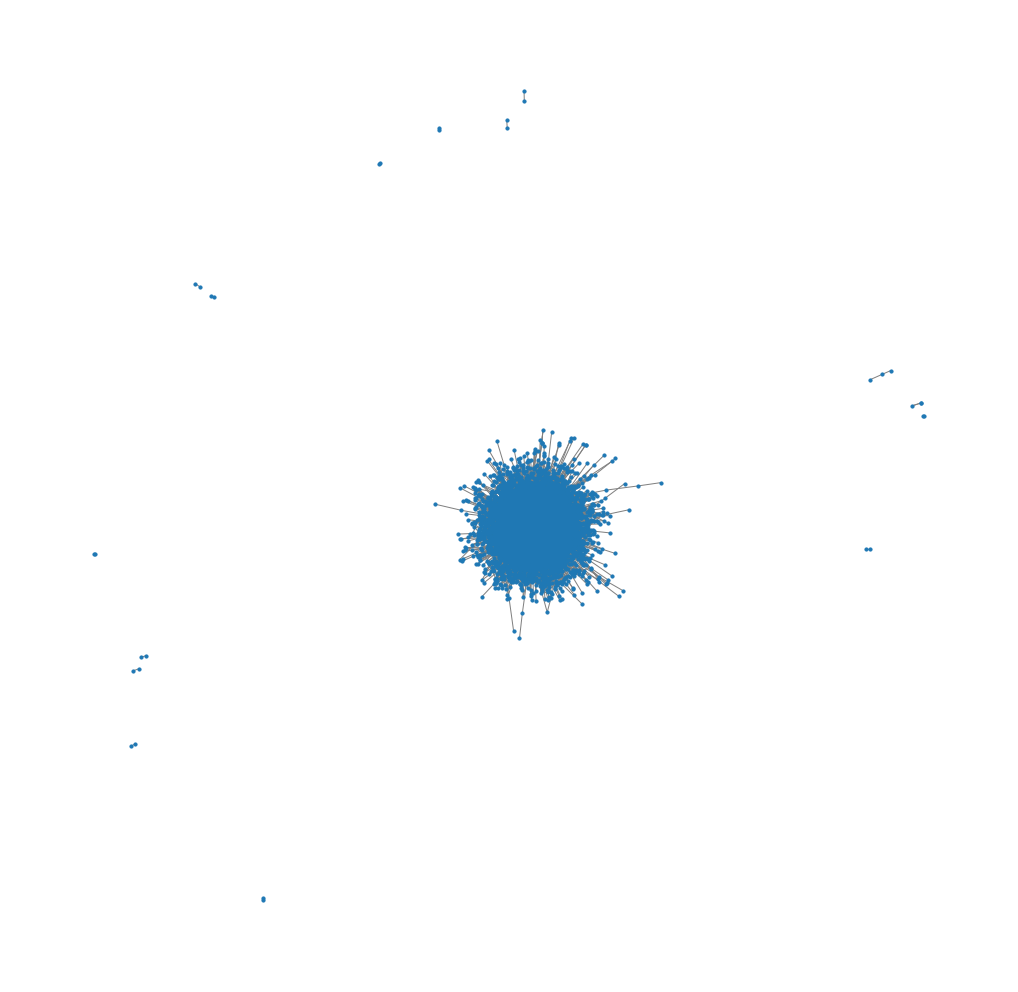

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,18))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

U = nx.from_pandas_edgelist(threes, source="from", target="to", edge_attr="weight")
nx.draw(U, pos=nx.spring_layout(U, seed=7), node_size=10, edge_color="gray", alpha=1)

In [7]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(U)
modularity = clouvain.modularity(partition, U)

In [9]:
print(type(partition), type(modularity))
pos = nx.spring_layout(U, dim=2)
community_id = [partition[node] for node in U.nodes()]

<class 'dict'> <class 'float'>


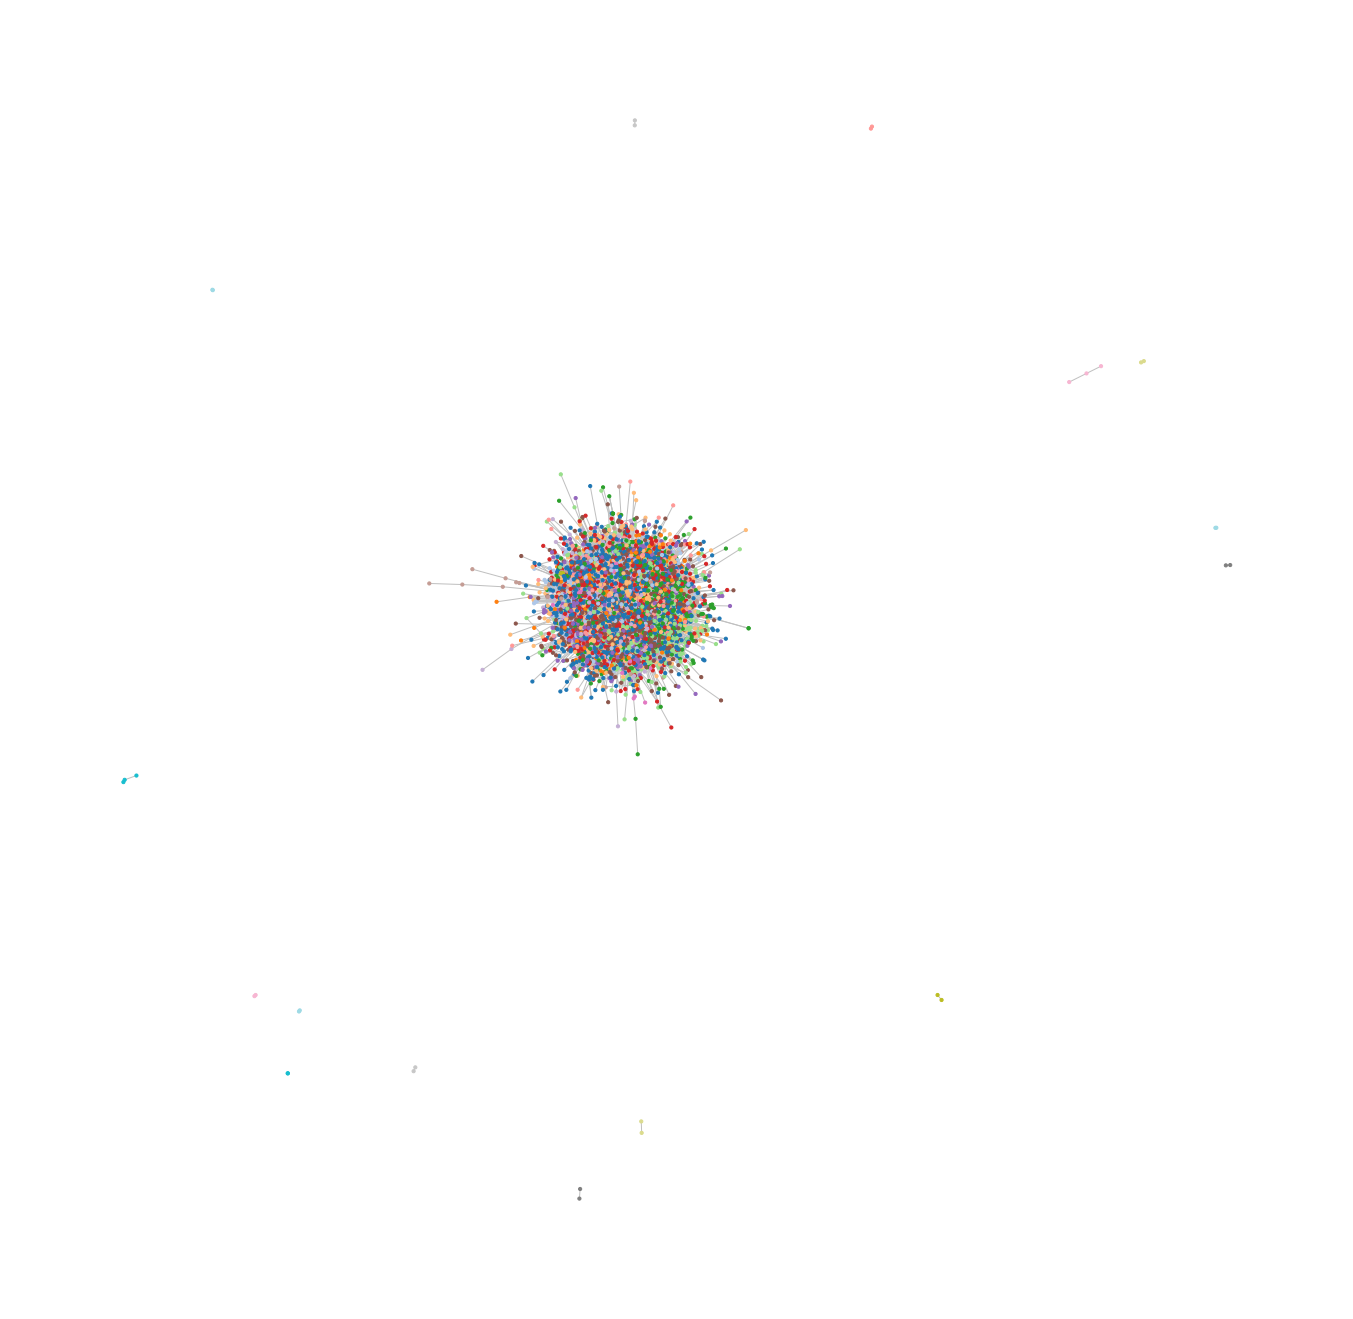

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(U, pos=pos, edge_color=['silver']*len(U.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=10, alpha=1)


In [23]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

print(elements_per_communities)

defaultdict(<class 'int'>, {'0': 1626, '1': 920, '2': 476, '3': 854, '4': 552, '5': 985, '6': 277, '7': 691, '22': 855, '9': 431, '10': 848, '11': 417, '12': 1749, '13': 1513, '14': 320, '15': 466, '8': 461, '17': 1064, '18': 458, '19': 566, '20': 87, '21': 833, '23': 274, '24': 135, '25': 192, '26': 63, '27': 110, '28': 2, '29': 3, '30': 2, '31': 2, '32': 2, '33': 2, '34': 3, '35': 2, '36': 2, '37': 2, '38': 3, '39': 2, '40': 2, '41': 2, '42': 2, '16': 2})


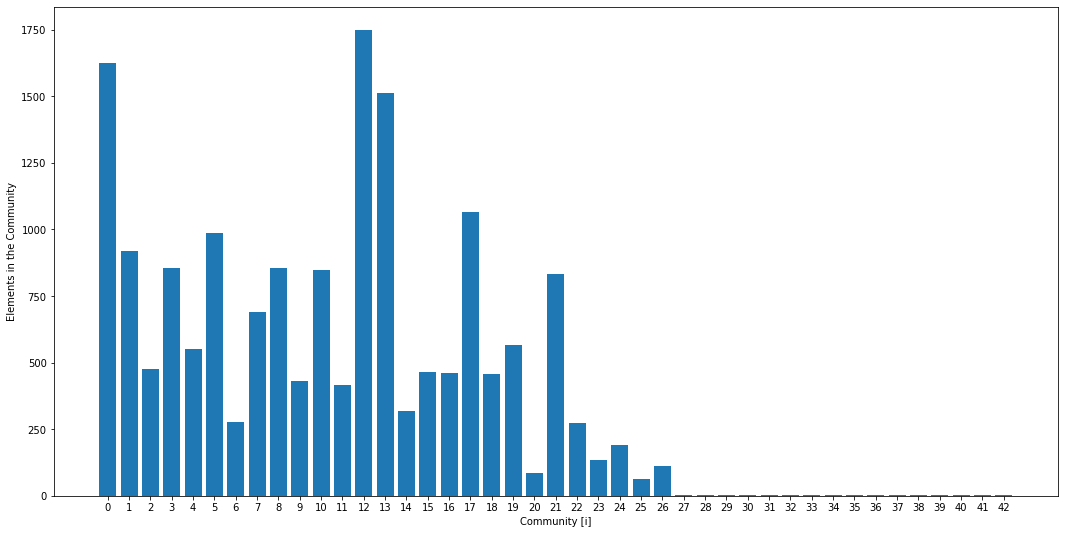

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)))#, elements_per_communities.keys())
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

In [35]:
titles_no_code["community"] = 0
titles_no_code.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body,dummy_index,community
2,NaN,NaN,NONE,I've got a problem from migrating from SB 2.3 ...,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T09:06:49Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076600016,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK5zQ,28977,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,DatabaseInitializationDependencyConfigurer tri...,2021-12-10T14:44:37Z,https://api.github.com/repos/spring-projects/s...,triggers eager initialization of factory beans,without code,got a problem from migrating from to When havi...,with code,0,0
3,NaN,NaN,MEMBER,NaN,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T08:44:05Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076581722,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK1Va,28976,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,2021-12-10T15:37:23Z,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,without code,NaN,without code,1,0
16,NaN,NaN,MEMBER,NaN,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-09T17:41:02Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1075834267,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AH-2b,28955,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Document that using DevTools with a remote app...,2021-12-09T17:41:02Z,https://api.github.com/repos/spring-projects/s...,Document that using with a remote application ...,without code,NaN,without code,2,0


In [36]:
wbuch = dict()

for key in range(titles_no_code.shape[0]):
    try:
        wbuch[key] = partition[key]
    except:
        wbuch[key] = -1


In [38]:
print(wbuch)

{0: 0, 1: 4, 2: 7, 3: 5, 4: 10, 5: 13, 6: -1, 7: 6, 8: 3, 9: 13, 10: 3, 11: 11, 12: 4, 13: 2, 14: 12, 15: 11, 16: 12, 17: 3, 18: 7, 19: 4, 20: 13, 21: 13, 22: 13, 23: 12, 24: 0, 25: 4, 26: 3, 27: 12, 28: 20, 29: 4, 30: 3, 31: 4, 32: 7, 33: 0, 34: 12, 35: 1, 36: 11, 37: 4, 38: 8, 39: 2, 40: 11, 41: 5, 42: 0, 43: 3, 44: 5, 45: 5, 46: 0, 47: 12, 48: 12, 49: 3, 50: 3, 51: 3, 52: 19, 53: 17, 54: 4, 55: 13, 56: 5, 57: 5, 58: 13, 59: 12, 60: 5, 61: 13, 62: 17, 63: 1, 64: 21, 65: 21, 66: 21, 67: 7, 68: 13, 69: 13, 70: 13, 71: 13, 72: 1, 73: 1, 74: 1, 75: 12, 76: 4, 77: 3, 78: 8, 79: 12, 80: 8, 81: 17, 82: 20, 83: -1, 84: 21, 85: 11, 86: 4, 87: 5, 88: 2, 89: 4, 90: 7, 91: 12, 92: 7, 93: 21, 94: -1, 95: 8, 96: 8, 97: 1, 98: 12, 99: 22, 100: 0, 101: 24, 102: 3, 103: 10, 104: 13, 105: -1, 106: 3, 107: 7, 108: 4, 109: 1, 110: 13, 111: 13, 112: 4, 113: 17, 114: 13, 115: 19, 116: 13, 117: 6, 118: 5, 119: 10, 120: 7, 121: 8, 122: 3, 123: 10, 124: 0, 125: 13, 126: 13, 127: 17, 128: 4, 129: 2, 130: 8, 1

In [39]:
titles_no_code["community"] = wbuch.values()
titles_no_code.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body,dummy_index,community
2,NaN,NaN,NONE,I've got a problem from migrating from SB 2.3 ...,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T09:06:49Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076600016,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK5zQ,28977,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,DatabaseInitializationDependencyConfigurer tri...,2021-12-10T14:44:37Z,https://api.github.com/repos/spring-projects/s...,triggers eager initialization of factory beans,without code,got a problem from migrating from to When havi...,with code,0,0
3,NaN,NaN,MEMBER,NaN,NaN,3,https://api.github.com/repos/spring-projects/s...,2021-12-10T08:44:05Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1076581722,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AK1Va,28976,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,2021-12-10T15:37:23Z,https://api.github.com/repos/spring-projects/s...,Reinstate support for Spring Data Couchbase,without code,NaN,without code,1,4
16,NaN,NaN,MEMBER,NaN,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-09T17:41:02Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1075834267,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AH-2b,28955,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Document that using DevTools with a remote app...,2021-12-09T17:41:02Z,https://api.github.com/repos/spring-projects/s...,Document that using with a remote application ...,without code,NaN,without code,2,7


In [40]:
# titles_no_code.to_csv("titles_no_code_communities.csv")

In [46]:
titles_no_code[titles_no_code["community"]==0]["clean_title"].sample(20)

22274         Compatibility between React Native and Litho
12300    Pooled Connections be closed if they have sock...
9684     Add option to automatically advance to the nex...
30234            monkey step is failing in releases script
23855                   Include invokable in error message
10707    should not return the entire table if predicat...
11726       Unable to send data to php script from android
14832    Eureka Client Basic auth fails with encoded ch...
14798                                       too monolithic
23971                                       Let also build
31851    bazel fetch seems to ignore so can fail due to...
30605                 Bazel query error with square braces
29724                                               tinker
22110                             Crash due to year format
12360                            Poposal lua script helper
26169                    display in preview if has rounded
23494    Automatically push javadoc to site on liquibas.

In [47]:
titles_no_code[titles_no_code["community"]==1]["clean_title"].sample(20)

5349                                          Fix typeface
172      In a health indicators in a parent context are...
23630            Fix javadoc publishing of maven artifacts
20072                                        potential bug
15140                     How to mockito a new object in a
13999                     invertible is incorrect for tags
26806    Hexagonal Tiled Maps not taking flipped coordi...
1024                     fix error without feature flag in
3759                                       in spec perfect
23849           Consider as a return type for some methods
16990                      Add models copy utility methods
17037                               Missing fields in spec
33717                                          Pivot table
22259                Fix support for disappear transitions
6944                                         Fix violation
21435    the calculation of the quaternion between two ...
29238                             upfetch layoutmanager 

In [48]:
titles_no_code[titles_no_code["community"]==2]["clean_title"].sample(20)

34141                    Composite Foreign Key Constraints
13129                              Prowarm Binding request
17722                      Runtime Reconfiguration pattern
10921    Correct the clause of the relation when expand...
10703                  Refactor path for materialized view
15882                      Default data source association
14747    Payment channels protocol is vulnerable to tx ...
16423    Foreign Key fields can show and edit the dicti...
30276    Main object not being notified when a collecti...
17649                                Implicit Lock pattern
19269    Parser fails on nested record within annotatio...
17683                  Functional imperative shell pattern
1617                             Tighter for aggs on nodes
26975    Command names must be unique for the metrics t...
33658    Allow explicit labeling of record keys and rec...
18514           Allow using transport without the registry
17726                                   Gatekeeper patte

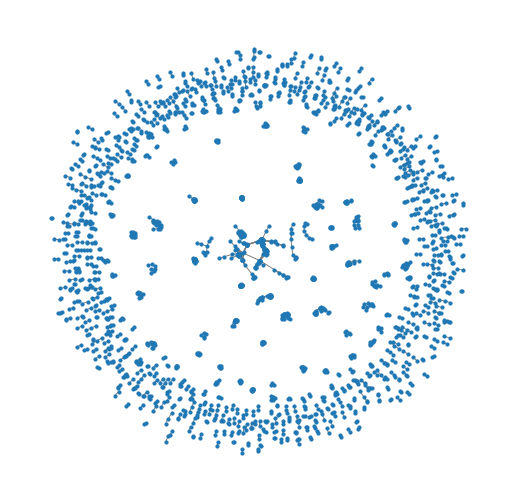

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

U = nx.from_pandas_edgelist(sevens, source="from", target="to", edge_attr="weight")
nx.draw(U, pos=nx.spring_layout(U, seed=7), node_size=10, edge_color="gray", alpha=1)

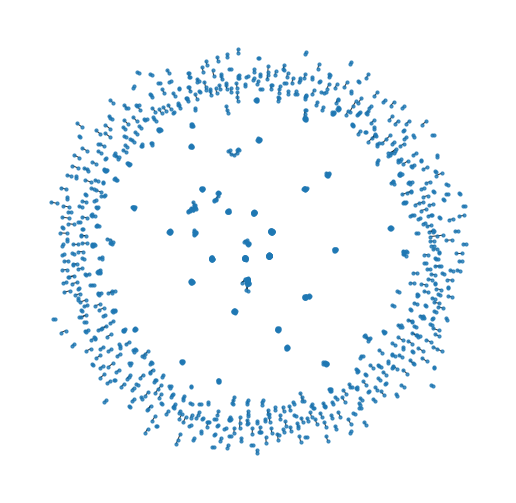

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

V = nx.from_pandas_edgelist(eights, source="from", target="to", edge_attr="weight")
nx.draw(V, pos=nx.spring_layout(V, seed=7), node_size=10, edge_color="k", alpha=0.8)

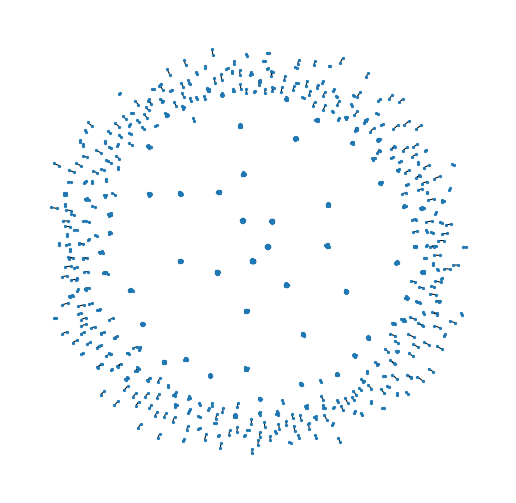

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

W = nx.from_pandas_edgelist(nines, source="from", target="to", edge_attr="weight")
nx.draw(W, pos=nx.spring_layout(W, seed=7), node_size=5, edge_color="k", alpha=1)

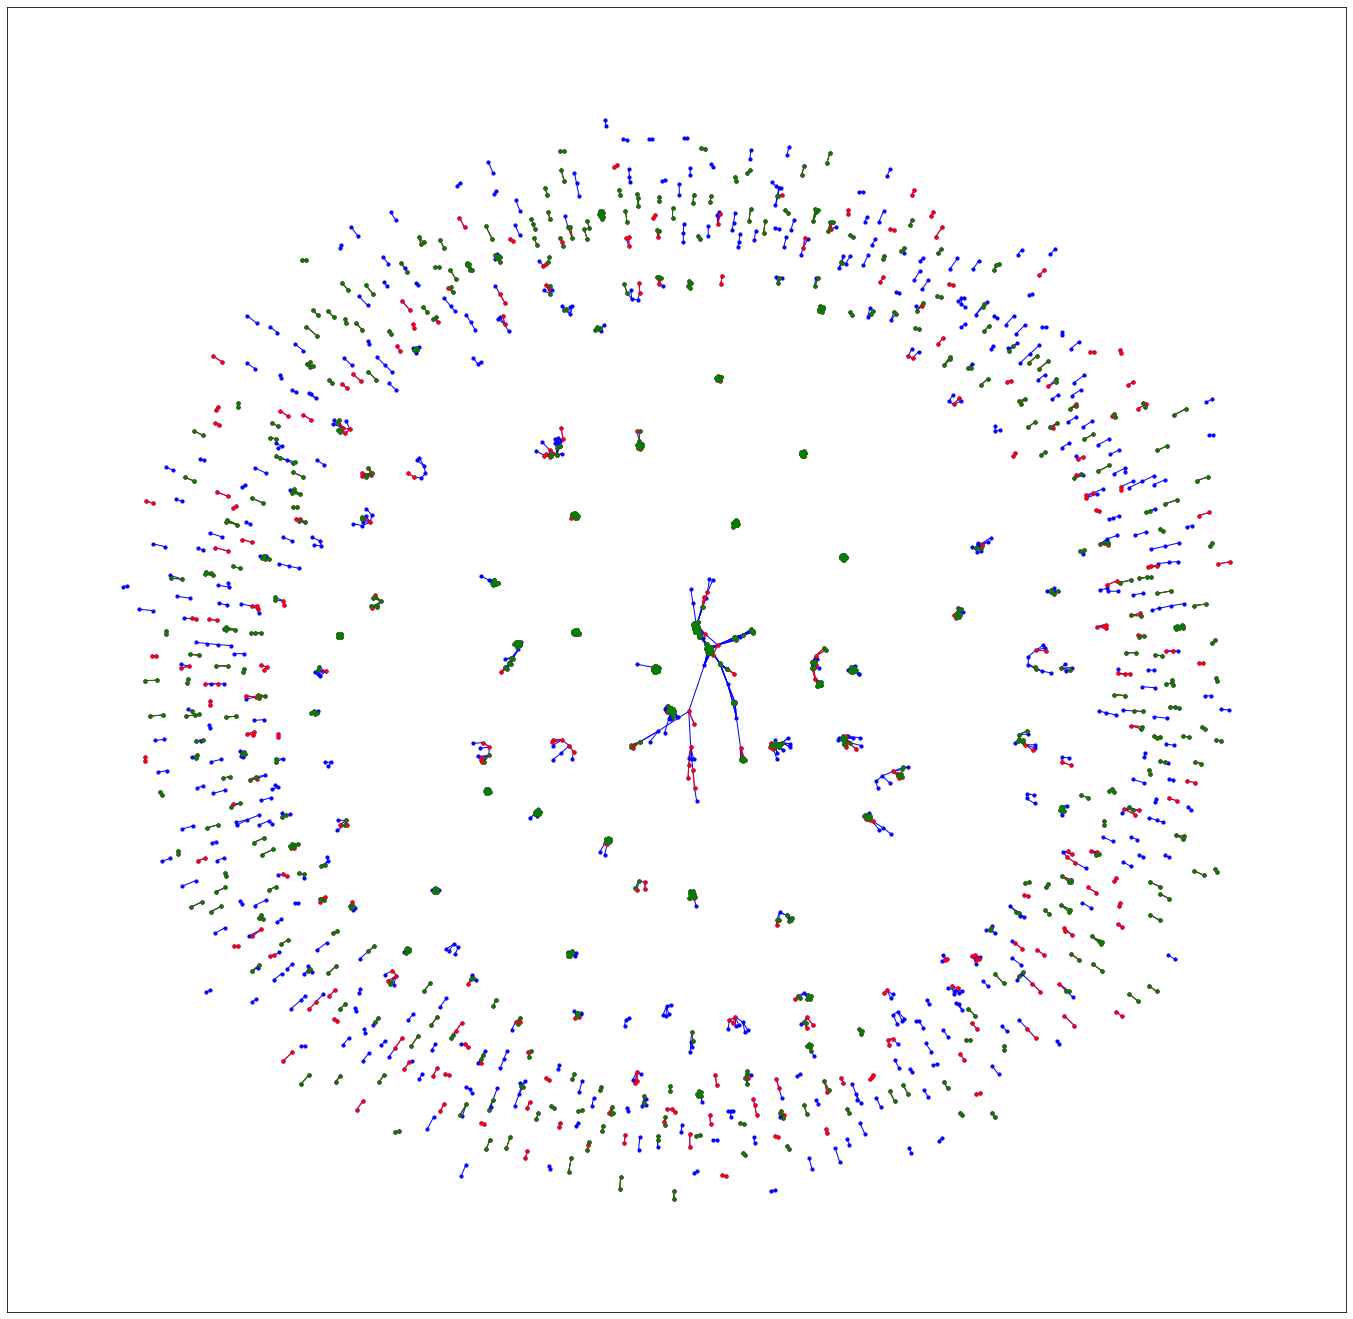

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

G = nx.Graph()
G.add_edges_from(U.edges)
G.add_edges_from(V.edges)
G.add_edges_from(W.edges)

pos = nx.spring_layout(G, seed=7)

nx.draw_networkx_nodes(U, pos=pos, nodelist=U.nodes, node_color="blue", node_size=10)
nx.draw_networkx_nodes(V, pos=pos, nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(W, pos=pos, nodelist=W.nodes, node_color="green", node_size=10)

nx.draw_networkx_edges(U, pos=pos, nodelist=U.edges, alpha=1, edge_color="blue");
nx.draw_networkx_edges(V, pos=pos, nodelist=V.edges, alpha=1, edge_color="red");
nx.draw_networkx_edges(W, pos=pos, nodelist=G.edges, alpha=1, edge_color="green");
# nx.draw(W, pos=nx.circular_layout(W))

In [20]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(G)
modularity = clouvain.modularity(partition, G)

In [21]:
print(type(partition), type(modularity))
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]

<class 'dict'> <class 'float'>


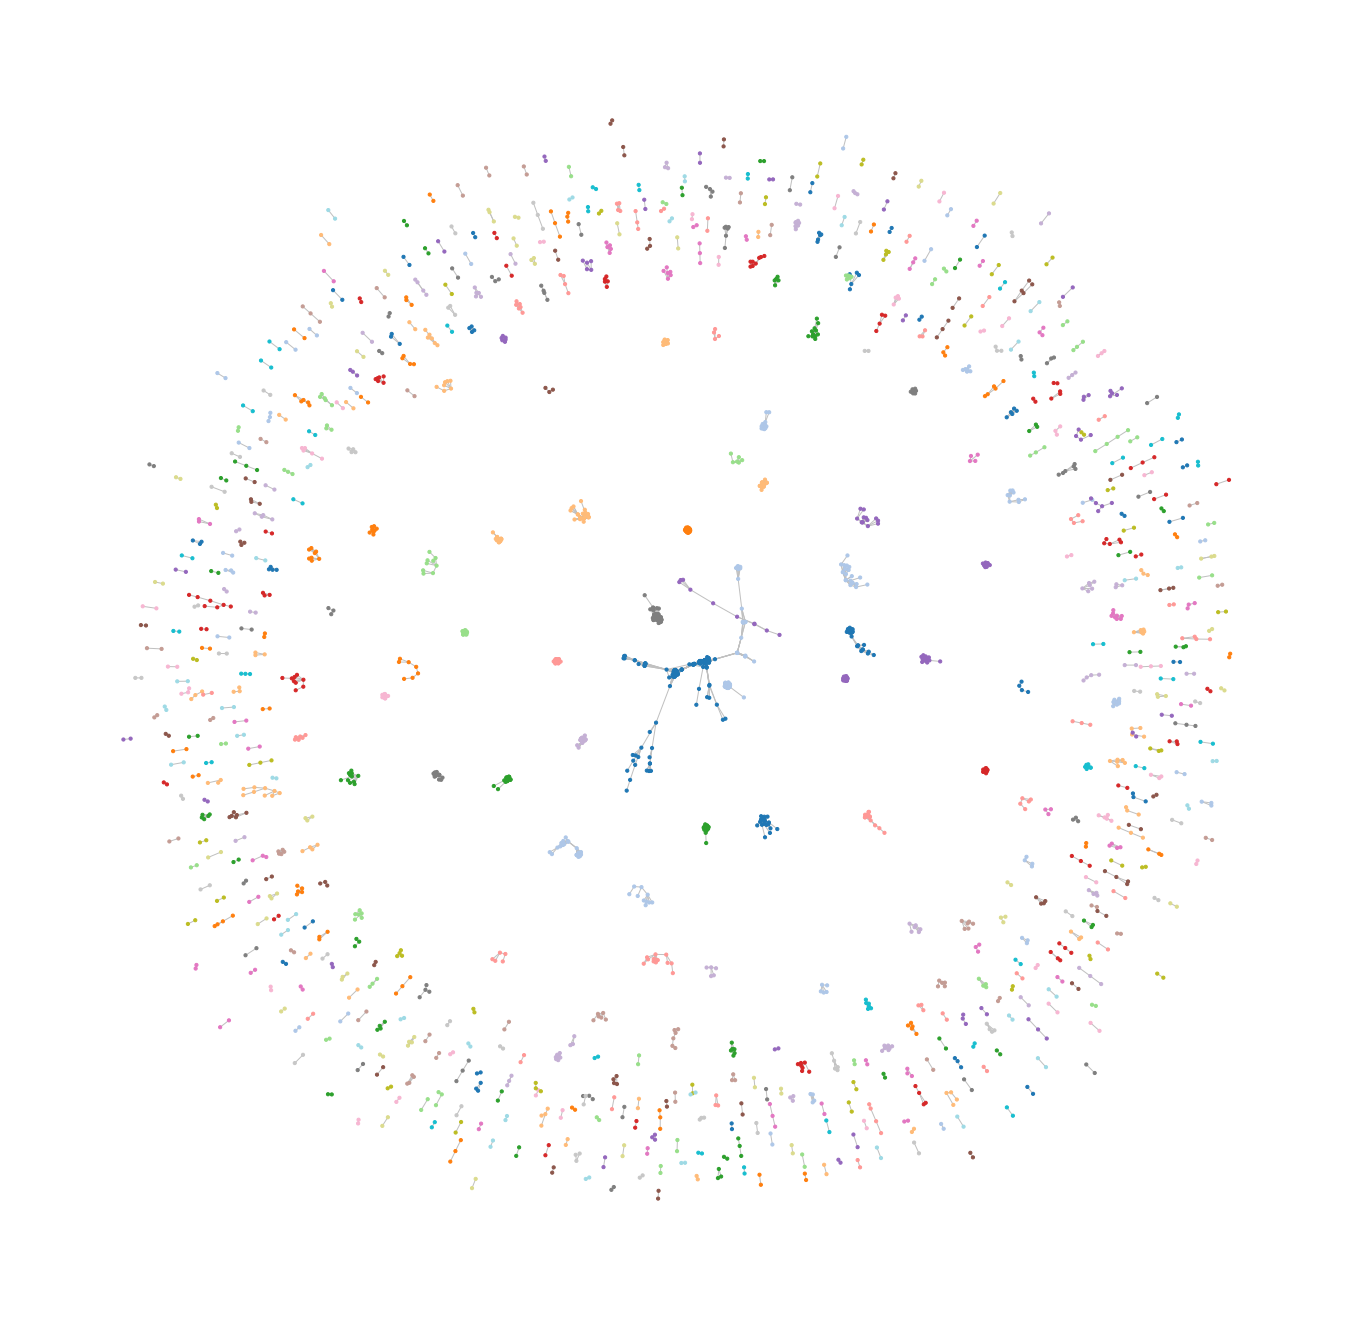

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(G, pos=pos, edge_color=['silver']*len(G.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=10, alpha=1)

In [23]:
type(community_id), len(community_id)

(list, 2489)

In [ ]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

In [ ]:
elements_per_communities

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

## Labeling

In [ ]:
graffi = graff[graff["weight"]>=float(0.4)]

In [ ]:
graffi.shape

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

G = nx.from_pandas_edgelist(graffi, source="from", target="to", edge_attr="weight")
nx.draw(G, node_size=10, edge_color="k")


In [ ]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(G)
modularity = clouvain.modularity(partition, G)

In [ ]:
print(type(partition), type(modularity))
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
print(len(community_id))

In [ ]:
len(partition)

In [ ]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

In [ ]:
sum(elements_per_communities.values())

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

cmap = cm.get_cmap("viridis", max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()

In [ ]:
title, cluster = [], []
for i in partition.items():
    title.append(titles_no_code["clean_title"][i])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [ ]:
frame_clust.shape

In [ ]:
frame_clust

In [ ]:
titles_no_code["clean_title"]

In [ ]:
U.clear()
V.clear()
W.clear()

In [ ]:
import networkx as nx
U = nx.Graph()
U.add_edges_from([(1,3), (1,4), (2,3), (2,4), (2,5), (1,6), (6,7), (6,8)])
nx.draw_networkx_labels(U, pos=nx.circular_layout(U))
nx.draw(U, pos=nx.circular_layout(U))

In [ ]:
V = nx.Graph()
V.add_edges_from([(5,1), (5,2), (5,3), (5,4), (5,6), (6,2)])
nx.draw_networkx_labels(V, pos=nx.circular_layout(V))
nx.draw(V, pos=nx.circular_layout(V))

In [ ]:
W = nx.Graph()
W.add_edges_from(U.edges)
W.add_edges_from(V.edges)

nx.draw_networkx_nodes(V, pos=nx.circular_layout(W), nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(U, pos=nx.circular_layout(W), nodelist=U.nodes, node_color="blue", node_size=100)

nx.draw_networkx_edges(U, pos=nx.circular_layout(W), nodelist=U.edges, edge_color="gray");
nx.draw_networkx_edges(V, pos=nx.circular_layout(W), nodelist=V.edges, edge_color="k", style="dashed");
# nx.draw(W, pos=nx.circular_layout(W))

In [ ]:
W.weight

In [ ]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(W)
modularity = clouvain.modularity(partition, W)

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(W, dim=2)
community_id = [partition[node] for node in W.nodes()]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(W, pos, edge_color = ['silver']*len(W.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [ ]:
import pandas as pd

title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']
frame_clust